In [2]:
# Copied from https://www.kaggle.com/code/pranjalsoni17/natural-scene-classification/comments

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "./kaggle/input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
import time
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Subset

%matplotlib inline

In [4]:
# Set the constants
project_name = 'natural-scene-classification'

train_data_dir = "./intel-image-classification/input/seg_train/seg_train"
test_data_dir = "./intel-image-classification/input/seg_test/seg_test"
pred_data_dir = "./intel-image-classification/input/seg_pred/seg_pred"

frame_subsample_rate = 4
batch_size = 128 # was 128
image_size = 150 # was 150
num_epochs = 3 # was 30
opt_func = torch.optim.Adam
learning_rate = 0.001

skip_browsing = True


> # Exploring the Dataset

In [5]:
building_files = os.listdir(train_data_dir + '/buildings')
print(f"Number of Buildings : {len(building_files)}")
print(building_files[:5])

Number of Buildings : 2191
['12536.jpg', '16750.jpg', '16988.jpg', '4571.jpg', '12244.jpg']


In [6]:
train_dataset = ImageFolder(train_data_dir,transform = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor()
]))
frame = 1000
print("3 channel image", train_dataset[frame][0].shape) # 3 channel image
print("label", train_dataset[frame][1]) # label
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor()
]))

3 channel image torch.Size([3, 150, 150])
label 0


In [7]:
img, label = train_dataset[0]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


The images are rgb and have f"{image_size}*{image_size}" pixel in each image

In [8]:
print(f"Images in train data : {len(train_dataset)}")
print(f"Images in test data : {len(test_dataset)}")

Images in train data : 14034
Images in test data : 3000


We have 14034 images in training data and 3000 images in test dataset.

In [9]:
print("Following classes are there : \n",train_dataset.classes)

Following classes are there : 
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [10]:
def display_img(img,label):
    if skip_browsing:
        return
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

> # Visualizing some images :

In [ ]:
display_img(*train_dataset[0])

In [ ]:
display_img(*train_dataset[5000])

In [ ]:
display_img(*train_dataset[8000])

> # Training and Validation Datasets : 

In [11]:
random_seed = 2021
torch.manual_seed(random_seed)

In [12]:
val_size = 2000
train_size = len(train_dataset) - val_size 

train_data,val_data = random_split(train_dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 12034
Length of Validation Data : 2000


> # Load the dataset into batches:

In [13]:
subsampled_train_data = torch.utils.data.Subset(train_data, list(range(0, len(train_data), frame_subsample_rate)))
train_dl = DataLoader(subsampled_train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
subsampled_val_data = torch.utils.data.Subset(val_data, list(range(0, len(val_data), frame_subsample_rate)))
val_dl = DataLoader(subsampled_val_data, batch_size*2, num_workers = 4, pin_memory = True)

In [14]:
from torchvision.utils import make_grid

def show_batch(dl):
    # if skip_browsing:
    #     return
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

> # **Grid Of Train Data Images :**

24


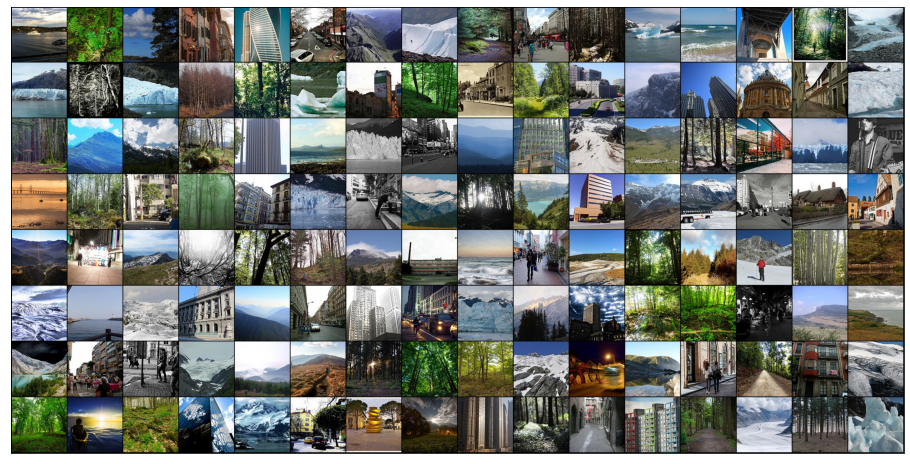

In [15]:
print(len(train_dl))
show_batch(train_dl) # 18 secs

> # Base Model for Image Classification:

In [15]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Netural Scene Classfication Model:

In [16]:
class NaturalSceneClassification(ImageClassificationBase):
    
    def __init__(self):
        
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            # compute these for a given image size
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [17]:
model = NaturalSceneClassification()
model

NaturalSceneClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Li

In [3]:
batch_cnt = 0
num_batches = len(train_dl) ## the number of batch_length batches
total_samples = num_batches * batch_size
print("total_samples:", total_samples, "num_batches:", num_batches)
for images, labels in train_dl:
    # if skip_browsing:
    #     break
    print(f'batch:{batch_cnt}/{num_batches}')
    print('images.shape:', images.shape)
    N = len(labels)
    print('labels.len:', N)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    print(f'out[{N-1}]:', out[N-1])
    batch_cnt += 1
    # break

NameError: name 'train_dl' is not defined

Helper Function or classes to Load Data into GPU

In [ ]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [ ]:
device = get_default_device()
device

In [ ]:
# load the datasets and the model into the device (GPU if available)
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

> # **Model Fitting**

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(num_epochs, learning_rate, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    total_elapsed = 0.0
    optimizer = opt_func(model.parameters(),learning_rate)
    for epoch in range(num_epochs):
                
        epoch_start = time.perf_counter()
        remaining = total_elapsed/epoch * (num_epochs-epoch) if epoch > 0 else 0.0
        remain = f"remaining: {remaining:9.2f}s" if remaining > 0.0 else ""
        print(f"{total_elapsed:9.2}s epoch:{epoch:3d}/{str(num_epochs).ljust(4)} {remain}")
        
        model.train()
        
        train_losses = []
        batch_cnt = 0
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            print(f"batch:{batch_cnt}")
            batch_cnt += 1
        
        # evaluate vals against model
        result = evaluate(model, val_loader)

        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
        epoch_elapsed = time.perf_counter() - epoch_start
        total_elapsed += epoch_elapsed
    
    return history

In [ ]:
#load the model to the device
model = to_device(NaturalSceneClassification(),device)

In [ ]:
#initial evaluation of the model (about 3 min)
evaluate(model,val_dl)

In [ ]:
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, learning_rate, model, train_dl, val_dl, opt_func)

> # Graphs for Model Accuracy and Losses :

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

In [ ]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

> # Evaluate Test Data :

In [ ]:
# Apply the model on test dataset and Get the results
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

In [ ]:
#save the model
torch.save(model.state_dict(), 'natural-scene-classification.pth')

> ## Predicting for individual images:

In [ ]:
def predict_img_class(img,model):
    """ Predict the class of image and Return Predicted Class"""
    img = to_device(img.unsqueeze(0), device)
    prediction =  model(img)
    _, preds = torch.max(prediction, dim = 1)
    return dataset.classes[preds[0].item()]

In [ ]:
from PIL import Image

#open image file
img = Image.open(pred_data_dir + "/10004.jpg")

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model)}")

In [ ]:
#open image file
img = Image.open(pred_data_dir + "/10100.jpg")

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model)}")

In [ ]:
#open image file
img = Image.open(pred_data_dir + "/10241.jpg")

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model)}")

In [ ]:
img.shape